# [Insert Creative Title HERE]

## Introduction and Motivation

## Required Libraries

Intro to Pandas:
https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html

Learning the Spotify API through spotipy:
https://spotipy.readthedocs.io/en/latest/#


In [1]:
import sys
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition, metrics
import plotly.graph_objects as go
import seaborn

## Data Collection and Tidying
//TODO Talk about general authentication flow.<br>
//TODO Link example resource. <br>
//TODO Explain how to get the spotify username<br>
//TODO talk about how we chose what columns to keep. Talk about how data is relatively simple and no need to reorganize

In [17]:
# Generate authorization token for reading user library
username = '12124976904'

scope = 'user-library-read'
client_id = '076ff5215a374d2481d0117877d79b74'
client_secret = '0ff2fd29106e4b7ebd7da4152d4a20c3'
redirect_uri = 'https://www.google.com/'

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)

else:
    print("Can't get token for", username)
    sys.exit()



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=076ff5215a374d2481d0117877d79b74&response_type=code&redirect_uri=https%3A%2F%2Fwww.google.com%2F&scope=user-library-read in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQB2Qm1IHsKmaNY0iN-pJI1WrNLpw288EtCkpiuYLVstTXHQOsN87f7QASRn2RrQKihgAIIE5WEGabUj4OmCQOeDVQVNZhYAi6mH-SizCpvteKU46AU4IJkTo8TMzQxPvKnX1Pu9ewij6Z09hetHNM-HZV4LeBp5Iu9AtrtiDVCCBSziOuN5rO5UaSjrEbNackAgZqzlacKcBbur_lstRw




//TODO explain the code flow <br>
//TODO talk about how we chose what columns to keep. <br>
//TODO Talk about how data is relatively simple and no need to reorganize <br>

In [18]:
def get_saved_tracks():
    results = sp.current_user_saved_tracks()
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

print('Loading Saved Tracks Now. Please be patient!')

if True:
    tracks = get_saved_tracks()
    features = []
    track_info = []
    for track in tracks:
        features.extend(sp.audio_features(track['track']['uri']))
        track_info.append([track['track']['name'], track['track']['artists'][0]['name']])

    features = pd.DataFrame.from_records(features)
    track_info = pd.DataFrame.from_records(track_info)
    track_info = track_info.rename(columns={0: "title", 1: "artist"})
    #features = pd.concat([track_info,features],axis=1)
    features = features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
    features['tempo'] = (features['tempo']-features['tempo'].min())/(features['tempo'].max()-features['tempo'].min())

else:
    features = pd.read_csv('sample_data') #TODO download the dataframe as a csv and add to path
    
features #TODO Add Name and Artist

Loading Saved Tracks Now. Please be patient!


,acousticness,danceability,energy,instrumentalness,tempo,valence
0,0.847000,0.342,0.352,0.899,0.280701,0.0371
1,0.872000,0.318,0.590,0.911,0.404077,0.0317
2,0.815000,0.527,0.332,0.506,0.360837,0.0362
3,0.521000,0.619,0.606,0.541,0.532921,0.4210
4,0.635000,0.544,0.512,0.595,0.471877,0.3600
...,...,...,...,...,...,...
93,0.000018,0.312,0.794,0.361,0.550520,0.4270
94,0.132000,0.536,0.693,0.557,0.477839,0.5360
95,0.000079,0.396,0.760,0.243,0.481419,0.1940
96,0.003340,0.153,0.556,0.880,0.298057,0.0373


## Exploratory Data Analysis & Visualizations

In [ ]:
#Explain the columns and how values are determined.
# Summary Statistics
# Histograms
# Correlation Graphs

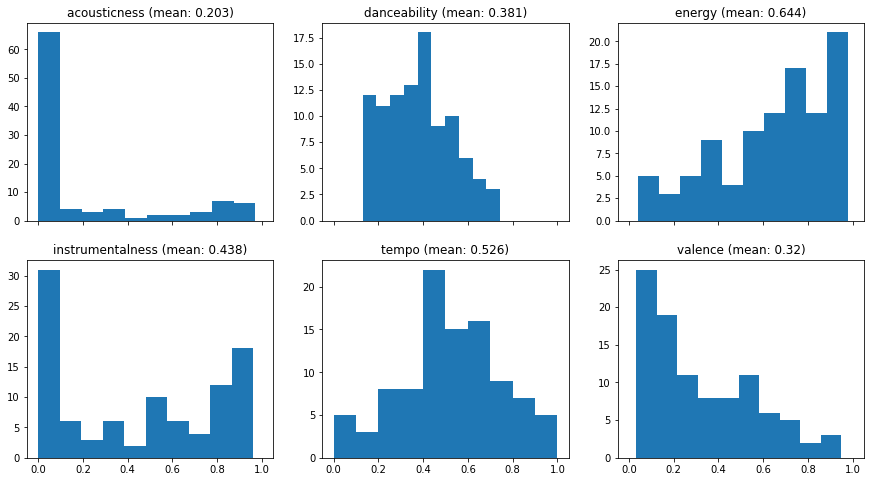

In [19]:
fig, ax = plt.subplots(2, 3, sharex=True, figsize=(15,8))
ax = ax.flatten()
idx = 0

for col in features.columns:
    ax[idx].hist(features[col])
    ax[idx].set_title(col + " (mean: " + str(np.round(features[col].mean(), 3)) + ")")
    idx += 1

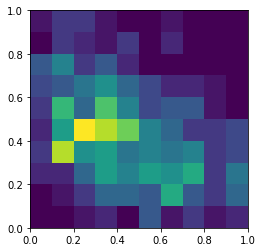

In [17]:
h, xedges, yedges = np.histogram2d(features['energy'], features['valence'])
plt.imshow(h, extent=[0, 1, 0, 1])

features.iloc[clusters.cluster_centers_indices_]

## Machine Learning

In [ ]:
# Found cool article on PCA & One Class SVM here:
# https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3
# Implementation is found here:
# http://www.esparsons.com/blogmain/2018/11/27/an-eclectic-spotify-library-visualized-with-chartify

#TODO One Class SVM
#TODO Clustering: Model selection (affinity propagation, mean shift, agglomerative clustering - davies-bouldin index)
#TODO get top songs from similar artists, match them to clusters, find closest matching songs with silhouette score,
#create playlists
#TODO EDA for the individual playlists (highlighting common features between library songs and recommended songs)

#TODO Error analysis...
#TODO Check if new playlists can fit into the SVM

### Clustering & Principal Component Analysis

In [20]:
affinity = cluster.AffinityPropagation(preference=0).fit(features.values)
pref = 0
db_scores = {}

while (len(affinity.cluster_centers_) > 10):
    pref -= 1
    affinity = cluster.AffinityPropagation(preference=pref).fit(features.values)
    
db_scores["Affinity Propagation"] = metrics.davies_bouldin_score(features.values, affinity.labels_)
    
for n in range(6, 11):
    aggl = cluster.AgglomerativeClustering(n_clusters=n).fit(features.values)
    db_scores["Agglomerative, n = " + str(n)] = metrics.davies_bouldin_score(features.values, aggl.labels_)
    
db_scores

{'Affinity Propagation': 1.3526810344885805,
 'Agglomerative, n = 6': 1.3256771153002058,
 'Agglomerative, n = 7': 1.4738383392686152,
 'Agglomerative, n = 8': 1.3855058294064546,
 'Agglomerative, n = 9': 1.2686446976050594,
 'Agglomerative, n = 10': 1.290766455363108}

In [35]:
clusters = cluster.AgglomerativeClustering(n_clusters=9).fit(features.values)
features['Cluster'] = clusters.labels_
track_info['Cluster'] = clusters.labels_

#Can play with this to see the songs in each cluster
track_info.loc[track_info['Cluster'] == 0]

,title,artist,Cluster
9,Love Gum,Eric Shoves Them in His Pockets,0
29,Man Makes the Zoo,USS (Ubiquitous Synergy Seeker),0
30,Stranger to Myself,USS (Ubiquitous Synergy Seeker),0
31,Anti-Venom,USS (Ubiquitous Synergy Seeker),0
46,NOTH1NG 3V3R CHAN935,Brainiac,0
47,PU55YFOOT1N',Brainiac,0
48,V1NC3NT COM3 ON DOWN,Brainiac,0
55,Buona Pizza,Tigers Jaw,0
57,Coil/Recoil,Tigers Jaw,0
58,Return,Tigers Jaw,0


In [25]:
pca = decomposition.PCA(n_components=2)
features_2d = pd.DataFrame(pca.fit_transform(features), columns=['Component 1', 'Component 2'])
features_2d['Cluster'] = clusters.labels_
print(pca.explained_variance_ratio_)
features_2d.head(10)

[0.95326699 0.02057067]


,Component 1,Component 2,Cluster
0,2.411585,0.776350,6
1,2.408307,0.660008,6
2,-0.608869,0.733658,3
3,0.376928,0.230882,4
4,0.385468,0.402133,4
5,2.400045,0.654181,6
6,2.407570,0.703668,6
7,0.404312,0.658740,4
8,1.368392,-0.234349,5
9,-3.635413,0.169060,0


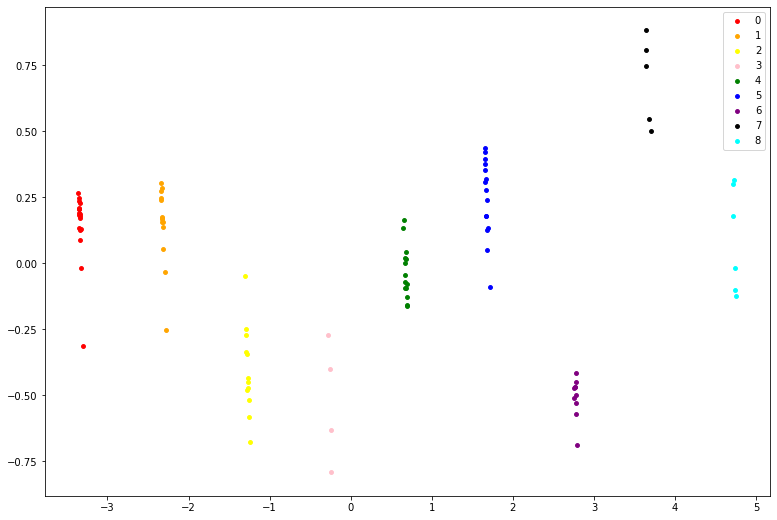

In [22]:
colors = ['red', 'orange', 'yellow', 'pink', 'green', 'blue', 'purple', 'black', 'cyan', 'grey']
fig, ax = plt.subplots(figsize=(13,9))
features_2d = features_2d.sort_values('Cluster')

for cluster_label in features_2d['Cluster'].unique():
    group = features_2d.loc[features_2d['Cluster'] == cluster_label]
    ax.scatter(group['Component 1'], group['Component 2'], c = colors[cluster_label], label=cluster_label, s=15)
    
ax.legend()

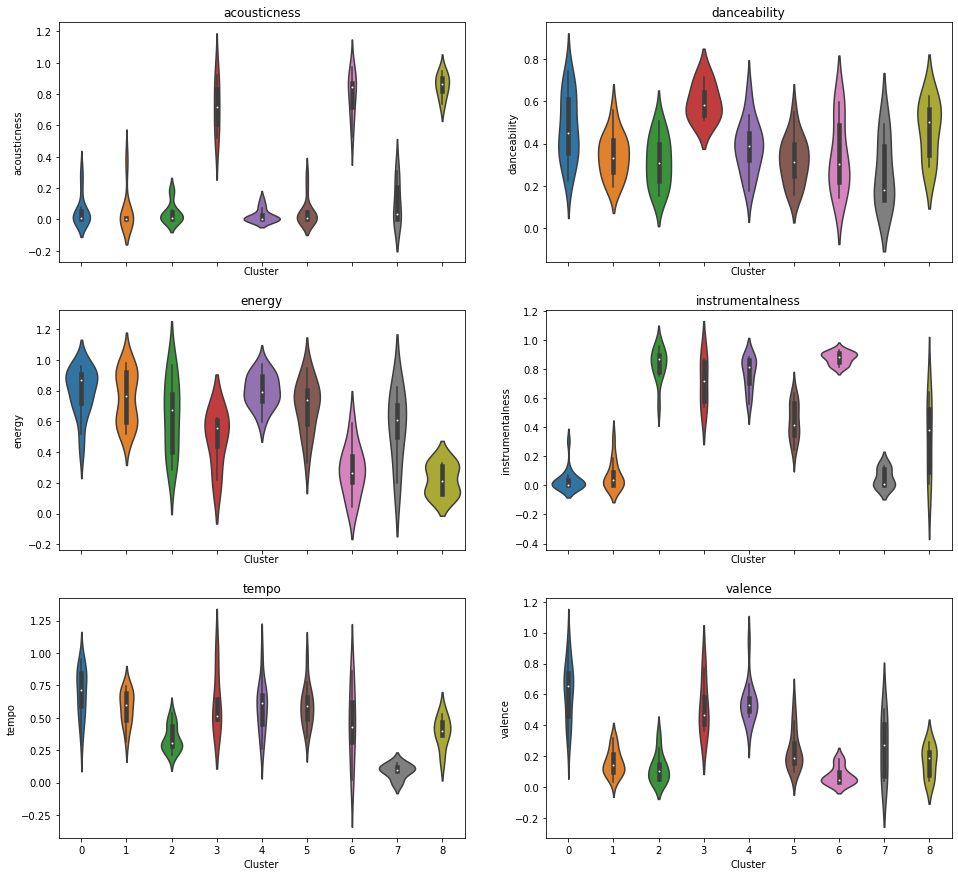

In [23]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(16, 15))
ax = ax.flatten()
idx = 0

for col in features.loc[:,:'valence'].columns:
    seaborn.violinplot(features['Cluster'], features[col], ax=ax[idx])
    ax[idx].set_title(col)
    idx += 1

### Finding Similar Songs

In [45]:
artists = track_info.groupby('artist').count().drop('Cluster', axis=1).reset_index().rename(columns={"title": "count"})
artists = artists.sort_values('count', ascending=False)


,artist,count
39,Unwound,16
28,Pygmy Lush,10
36,Tigers Jaw,7
4,Bert Love,6
30,Sleepytime Trio,5
35,Swivel Stick,5
38,USS (Ubiquitous Synergy Seeker),4
6,Brainiac,4
24,Malady,3
9,Cerberus Shoal,3


## Takeaways 

,title,artist,Cluster
12,Waving My Dick in the Wind,Ween,8
13,Unauthorized Autobiography,Unwound,8
17,Jesus Extract,Sleepytime Trio,8
18,Rock Candy,Sleepytime Trio,8
19,Flake City,Sleepytime Trio,8
20,30 Equals,Sleepytime Trio,8
21,Lancing Organic,Sleepytime Trio,8
23,Said Simone,Malady,8
42,Asphalt,Pygmy Lush,8
72,Remove Your Teeth,Stop It!!,8
